In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import odeint
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, HTML


# ODE based Numerical Simulations of QS Dynamics

In [137]:

# === Biological rate constants (units: 1/min or specified) ===
k1 = 0.1       # AHL + LuxR → complex (forward binding)
km1 = 10.0     # AHL + LuxR ← complex (reverse binding)
km2 = 1.0      # Complex binds promoter (LuxR dimer)
k2 = 0.05      # Promoter unbinding
k11 = 0.017    # Growth rate (1/min), ~40 min doubling time

# === Cell & Environment parameters ===
b = 0.04       # Dilution rate due to cell growth
D = 10.0       # Diffusion of AHL to environment
r = 1e-12      # V_cell / V_external
nmax = 1e11    # Carrying capacity (cells/mL)

# === Intrinsic degradation rates (not due to dilution) ===
k7 = 0.006     # LuxI degradation
k8 = 0.15      # LuxR degradation in unbound form
k9 = 0.005     # AHL degradation (changed in response to reviewer suggestion)

# === Basal expression levels ===
k5 = 8.0       # Basal LuxI production 
k6 = 8.0       # Basal LuxR production 
k10=0.5        # Basal GFP production 
# === Promoter activity ===
k3 = 80.0      # Activated LuxI production rate
k4 = 80.0      # Activated LuxR production rate

# === Dissociation constants (nM) ===
KdI = 100.0    # AHL-LuxR binding
KdR = 100.0    # LuxR dimer binding to DNA


# Plot settings
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


## Switch-like Behavior of QS Activation: Existence of ON and OFF Steady States


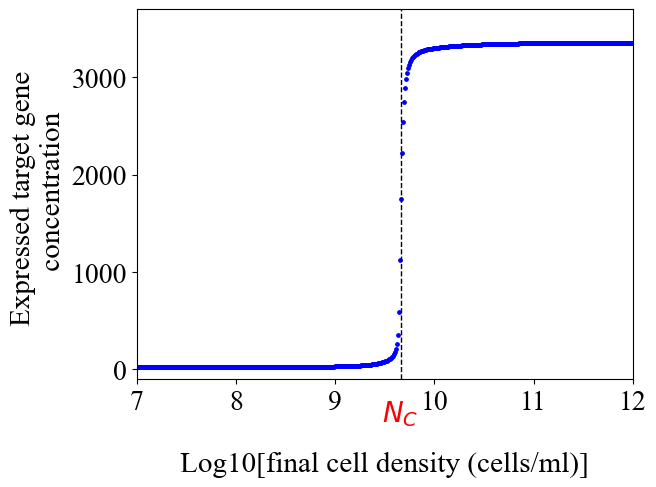

Molecule,OFF state (N_f = 1e7),ON state (N_f = 1e11)
LuxI,3.486e+02,3.678e+03
LuxR,4.794e+01,2.518e+01
R-AHL monomer,6.784e-01,2.141e+02
Dimer,2.263e-02,2.253e+03
AHL (in),1.418e+00,8.822e+02
AHL (ex),2.763e-02,8.775e+02
Cell count,1.000e+07,9.998e+10
GFP,2.253e+01,3.352e+03


In [138]:

# --- ODE system for LuxR-LuxI QS circuit  ---
def qs_memory_model(x, t, N_f):
    I, R, RA, C, A, Aex, n, G = x

    dIdt   = (k5 + k4 * C / (KdI + C) - k11 * I - k7 * I)
    dRdt   = (k6 + k3 * C / (KdR + C) - k8 * R - k1 * R * A + km1 * RA - k11 * R)
    dRAdt  = (k1 * R * A - km1 * RA - 2 * k2 * RA**2 + 2 * km2 * C - k11 * RA )
    dCdt   = (k2 * RA**2 - km2 * C - k11 * C)
    dAdt   = b * I + km1 * RA - k1 * R * A + D * (Aex - A) - k9 * A - k11 * A
    dAexdt = D * n * r * (A - Aex) - k9 * Aex
    dndt   = k11 * n * (1 - n / N_f)  # Logistic growth
    dGdt   = k10 + k4 * C / (KdI + C) - k11 * G - k7 * G

    return [dIdt, dRdt, dRAdt, dCdt, dAdt, dAexdt, dndt, dGdt]

# --- Simulate steady states across a range of final cell densities ---
gfp_steady_states = np.zeros(2000)
final_cell_densities = np.zeros(2000)

for i in range(2000):
    N_f = 10 ** (i / 100.)
    x0 = [0, 0, 0, 0, 0, 0, 1.0, 0]
    t = np.linspace(0, 2000, 20000)

    x = odeint(qs_memory_model, x0, t, args=(N_f,))
    gfp_steady_states[i] = x[-1, 7]         # Final GFP
    final_cell_densities[i] = N_f           # Corresponding N_f

# --- Find critical cell density where GFP ~ half-max ---
half_max = np.max(gfp_steady_states) / 2
index = np.argmin(np.abs(gfp_steady_states - half_max))
Nc_log = index / 100.

# --- Plot steady-state GFP vs. log10(cell density) ---
plt.scatter(np.log10(final_cell_densities), gfp_steady_states, s=6, c="b")
ax = plt.gca()
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylim(-100, 3700)
plt.xlabel("\nLog10[final cell density (cells/ml)]", size=21)
plt.ylabel("Expressed target gene \n concentration", size=21)

# Highlight the threshold (N_c)
plt.plot([Nc_log, Nc_log], [-100, 3900], c="k", linestyle="dashed", linewidth=1)
plt.xlim(7, 12)
plt.annotate("$N_C$", xy=(Nc_log * 1.1, -105), xytext=(Nc_log, -450),
             size=20, va="center", ha="center", color="r")

# --- Extract OFF and ON states for specific densities ---
def get_steady_state(N_f):
    x0 = [0, 0, 0, 0, 0, 0, 1.0, 0]
    t = np.linspace(0, 2000, 20000)
    x = odeint(qs_memory_model, x0, t, args=(N_f,))
    return x[-1]

OFF_state = get_steady_state(1e7)
ON_state = get_steady_state(1e11)
plt.show()

# --- Biomolecules Concentrations at OFF and ON states  ---


# Define names for each molecular species
species_labels = ["LuxI", "LuxR", "R-AHL monomer", "Dimer", "AHL (in)", "AHL (ex)", "Cell count", "GFP"]

# Create DataFrames for OFF and ON states
off_df = pd.DataFrame({"Molecule": species_labels, "OFF state (N_f = 1e7)": OFF_state})
on_df = pd.DataFrame({"Molecule": species_labels, "ON state (N_f = 1e11)": ON_state})

# Merge side-by-side for comparison
merged_df = pd.merge(off_df, on_df, on="Molecule")

# Display as an HTML table with styling
display(HTML(merged_df.to_html(index=False, float_format="%.3e")))


## Deactivation and Reacivation Dynamics of QS upon dilution wash of external signal in initially ON cells

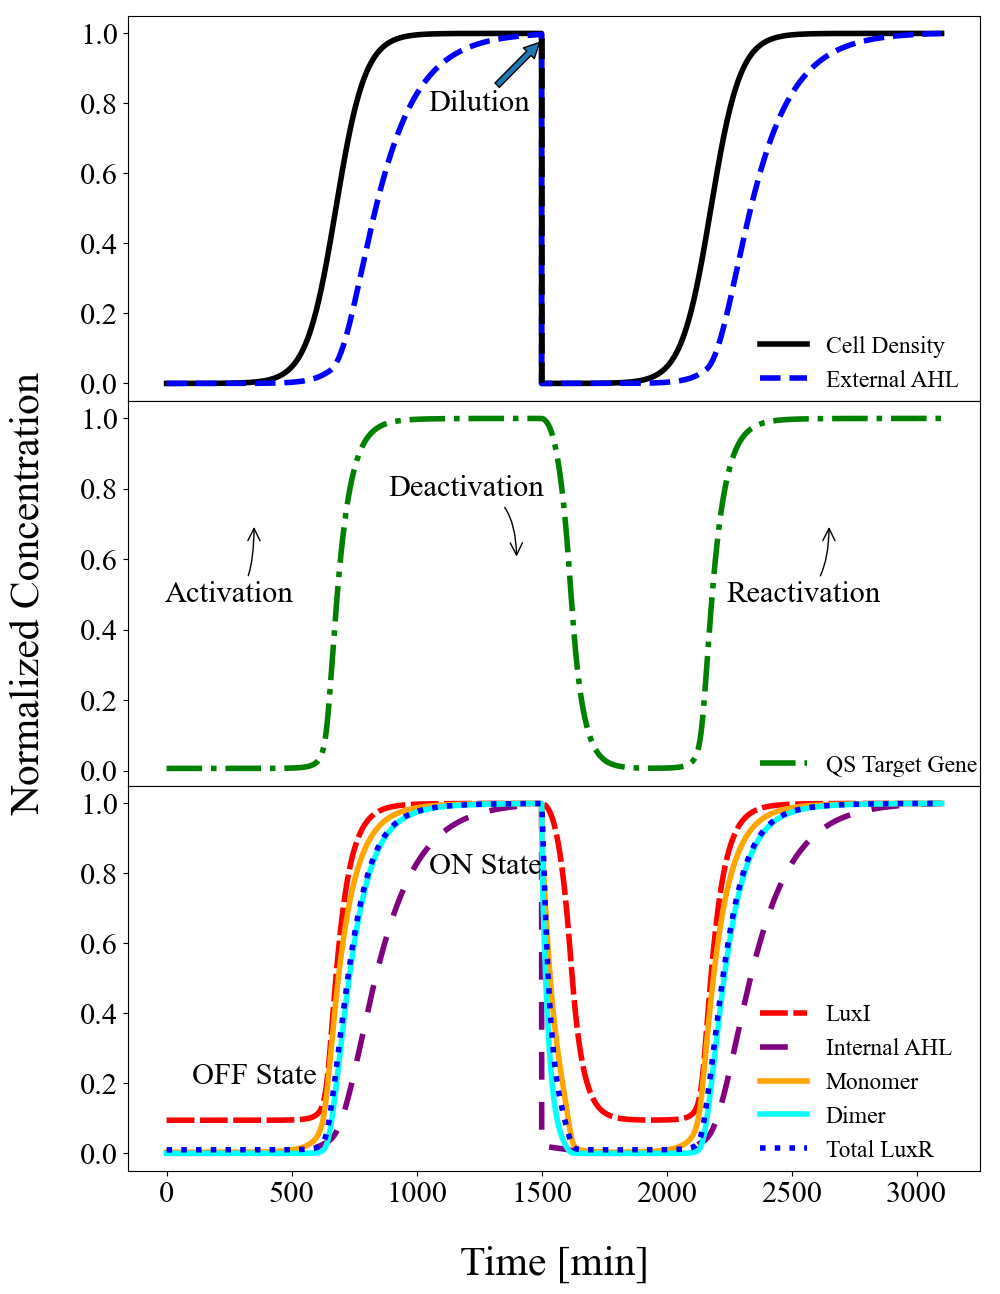

In [80]:
# --- Setup ---
%matplotlib inline

# Initial and final cell densities
N0 = 1e11         # Original final density (ON state)
n0_dilution = 1e6 # Diluted starting cell density
# Time vectors
t1 = np.linspace(0, 1500, 15000)     # Pre-dilution simulation
t2 = np.linspace(1500, 3100, 15000)  # Post-dilution simulation

# --- First segment: simulate activation from OFF to ON ---
x0_on = [OFF_state[0], OFF_state[1], OFF_state[2], OFF_state[3],
         OFF_state[4], OFF_state[5], n0_dilution, OFF_state[7]]
sol1 = odeint(qs_memory_model, x0_on, t1, args=(N0,))
On = sol1[-1]  # Final state (ON)

# --- Second segment: simulate memory decay after dilution ---
x0_diluted = [On[0], On[1], On[2], On[3], On[4], 0, n0_dilution, On[7]]
sol2 = odeint(qs_memory_model, x0_diluted, t2, args=(N0,))

# --- Combine time and solution arrays ---
t_combined = np.concatenate((t1, t2))
x_combined = np.vstack((sol1, sol2))
I, R, RA, C, A, Aex, n, G = x_combined.T

# --- Plotting ---
fig = plt.figure(figsize=(11, 15))
ax_big = fig.add_subplot(111, frameon=False)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Hide big axes
for spine in ax_big.spines.values():
    spine.set_visible(False)
ax_big.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

# Plot cell density and external AHL
ax1.plot(t_combined, n / n.max(), c="k", label="Cell Density", linewidth=4)
ax1.plot(t_combined, Aex / Aex.max(), c="b", linestyle="dashed", label="External AHL", linewidth=4)

# Plot target gene (GFP)
ax2.plot(t_combined, G / G.max(), c="g", linestyle='-.', label="QS Target Gene", linewidth=4)

# Plot internal species
ax3.plot(t_combined, I / I.max(), c="r", linestyle="dashed", dashes=(5, 1), label="LuxI", linewidth=4)
ax3.plot(t_combined, A / A.max(), c="purple", linestyle='--', dashes=(5, 4), label="Internal AHL", linewidth=4)
ax3.plot(t_combined, RA / RA.max(), c="orange", label="Monomer", linewidth=4)
ax3.plot(t_combined, C / C.max(), c="cyan", label="Dimer", linewidth=4)
ax3.plot(t_combined, (R + RA + 2 * C) / (R + RA + 2 * C).max(), c="b", linestyle="dotted", label="Total LuxR", linewidth=4)

# Axes styling
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.legend(loc=(0.73, 0), frameon=False, fontsize=17)

# Labels and annotations
ax_big.set_xlabel("\nTime [min]", size=30)
ax_big.set_ylabel("Normalized Concentration\n", size=30)
ax1.plot([1500, 1500], [0, 1], c="k", linestyle="dashed", linewidth=4)
ax3.text(100, 0.2, "OFF State", size=22)
ax3.text(1050, 0.8, "ON State", size=22)

# Arrows
ax1.annotate('Dilution', xy=(1500, 0.98), xytext=(1250, 0.8),
             size=22, ha="center", va="center",
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0"))
ax2.annotate('Activation', xy=(350, 0.7), xytext=(250, 0.5),
             size=22, ha="center", va="center",
             arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
ax2.annotate('Deactivation', xy=(1400, 0.6), xytext=(1200, 0.8),
             size=22, ha="center", va="center",
             arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))
ax2.annotate('Reactivation', xy=(2650, 0.7), xytext=(2550, 0.5),
             size=22, ha="center", va="center",
             arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=30,angleB=90"))

# Save figure
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('Memory_Fig1_C.tiff', format='tiff')


## Degradation rates of QS biomolecues through Deactivation

/var/folders/7w/pn98mc1x4338dn2v_bv9547m0000gn/T/ipykernel_2068/2508643360.py:23: RuntimeWarning: overflow encountered in multiply
  return lambda t, r: A0 * np.exp(-r * t) + baseline


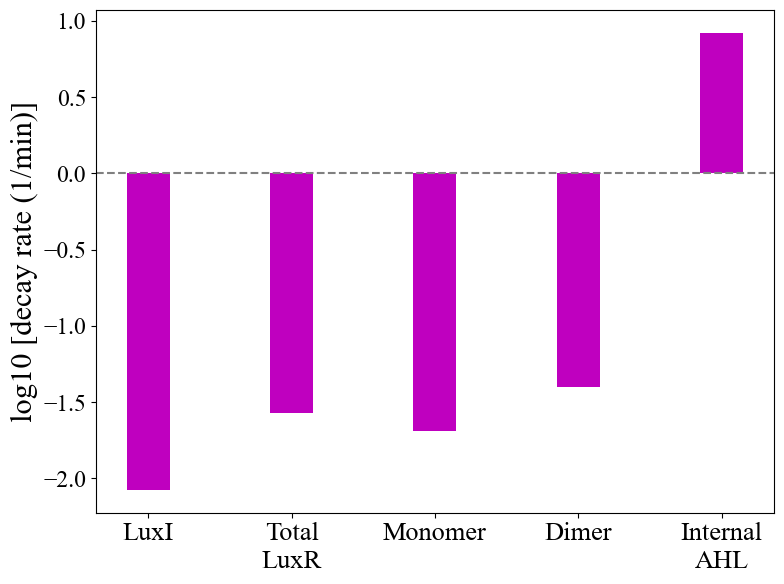

In [76]:

N_f = 1e11
epsilon = 2.  # How close species must be to OFF value to count as "deactivated"

# --- Start from ON state, wash Aex, and dilute to 1e6 ---
x0 = [ON_state[0], ON_state[1], ON_state[2], ON_state[3],
      ON_state[4], 0, 1e6, ON_state[7]]
t_full = np.linspace(0, 2000, 20000)

# --- Simulate dynamics ---
sol_full = odeint(qs_memory_model, x0, t_full, args=(N_f,))
I, R, RA, C, A = sol_full[:, 0], sol_full[:, 1], sol_full[:, 2], sol_full[:, 3], sol_full[:, 4]
R_total = R + RA + 2 * C

# --- Helper: find last time point before species reaches OFF state ---
def get_deactivation_end_idx(y, y_off, eps=epsilon):
    delta = np.abs(y - y_off)
    below_thresh = np.where(delta < eps)[0]
    return below_thresh[0] if len(below_thresh) > 0 else None

# --- Exponential decay model generator ---
def fit_exp_decay(y, A0, baseline):
    return lambda t, r: A0 * np.exp(-r * t) + baseline

# --- Fit one species safely ---
def fit_species_decay(species_name, y, y_on, y_off):
    idx = get_deactivation_end_idx(y, y_off)
    if idx is None or idx < 5:  # Skip if too short to fit
        print(f"{species_name}: did not reach OFF state or window too short.")
        return np.nan
    try:
        popt, _ = opt.curve_fit(fit_exp_decay(y[:idx], y_on, y_off), t_full[:idx], y[:idx])
        return popt[0]
    except Exception as e:
        print(f"{species_name}: fit failed — {e}")
        return np.nan

# --- Fit decay rates ---
labels = ["LuxI", "Total\nLuxR", "Monomer", "Dimer", "Internal\nAHL"]
rates = []

# LuxI
rates.append(fit_species_decay("LuxI", I, ON_state[0], OFF_state[0]))

# Total LuxR
R_on = ON_state[1] + ON_state[2] + 2 * ON_state[3]
R_off = OFF_state[1] + OFF_state[2] + 2 * OFF_state[3]
rates.append(fit_species_decay("Total LuxR", R_total, R_on, R_off))

# Monomer
rates.append(fit_species_decay("Monomer", RA, ON_state[2], OFF_state[2]))

# Dimer
rates.append(fit_species_decay("Dimer", C, ON_state[3], OFF_state[3]))

# Internal AHL
rates.append(fit_species_decay("Internal AHL", A, ON_state[4], OFF_state[4]))

# --- Plot ---
log_rates = np.log10(rates)
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, log_rates, width=0.3, color="m")
ax.axhline(y=0, color='gray', linestyle='dashed')
ax.set_ylabel("log10 [decay rate (1/min)]", size=22)
ax.set_xticks(x)
ax.set_xticklabels(labels, size=19)
ax.tick_params(axis='y', labelsize=17)
plt.tight_layout()
plt.savefig("Memory_Fig1_D_trueDeactivation.tiff", format="tiff", dpi=300)
plt.show()

# --- Save results ---
decay_data = pd.DataFrame({
    "Species": labels,
    "Decay Rates [1/min]": rates,
    "Log10 Decay Rates [1/min]": log_rates
})
decay_data.to_excel("Memory_Fig1_D_trueDeactivation.xlsx", index=False)


##  Earlier Activation of Initially ON Cells Near the QS Critical Cell Density
When the carrying capacity is close to the quorum sensing (QS) threshold, initially ON cells activate earlier than initially OFF cells.


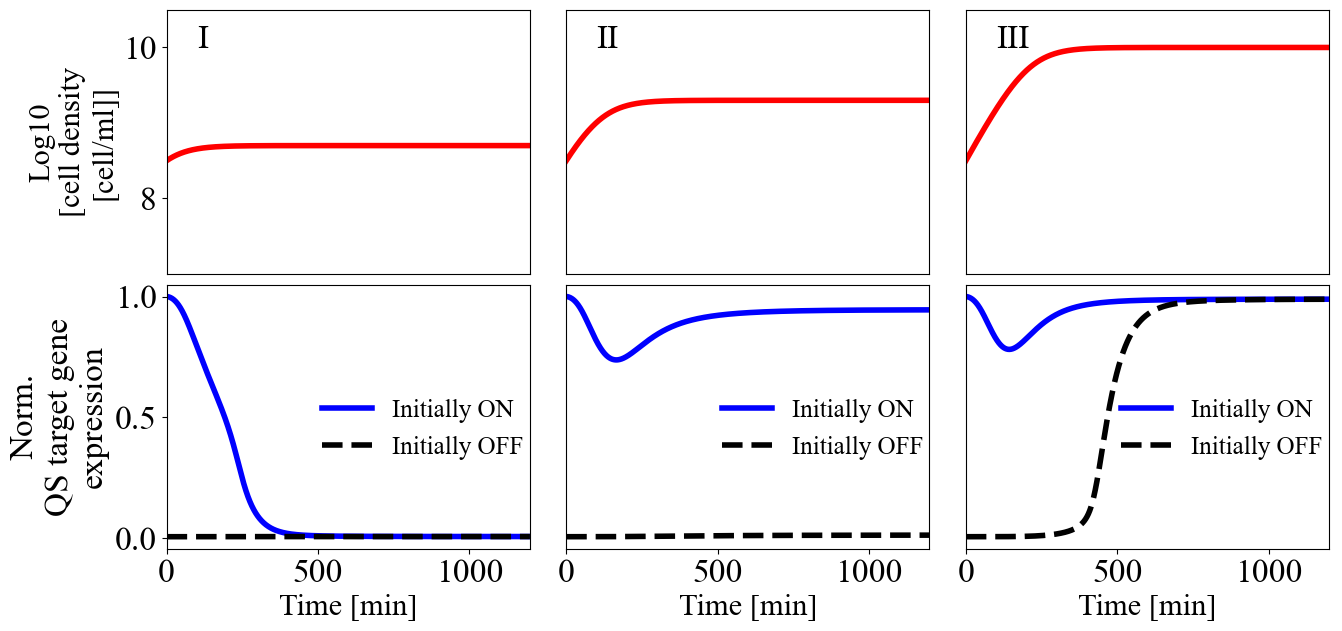

In [77]:

ON = ON_state   
OFF = OFF_state 

def qs_dynamics(x, t, n_max):
    I, R, RA, C, A, Aex, n, G = x
    dIdt = k5 + k4 * C / (KdI + C) - k11 * I - k7 * I  # LuxI
    dRdt = k6 + k3 * C / (KdR + C) - k8 * R - k1 * R * A + km1 * RA - k11 * R  # LuxR
    dRAdt = k1 * R * A - km1 * RA - 2 * k2 * RA**2 + 2 * km2 * C - k11 * RA  # Monomer
    dCdt = k2 * RA**2 - km2 * C - k11 * C  # Dimer
    dAdt = b * I + km1 * RA - k1 * R * A + D * (Aex - A) - k9 * A - k11 * A  # AHL (in)
    dAexdt = D * n * r * (A - Aex) - k9 * Aex  # AHL (ex)
    dndt = k11 * n * (1 - n / n_max)  # Cell density
    dGdt = k10 + k4 * C / (KdI + C) - k11 * G - k7 * G  # GFP
    return [dIdt, dRdt, dRAdt, dCdt, dAdt, dAexdt, dndt, dGdt]

# Function to simulate dynamics for a given initial state and final cell density
def simulate_dynamics(initial_state, n_max, t):
    x = odeint(qs_dynamics, initial_state, t, args=(n_max,))
    return x[:, 6], x[:, 7]  # Return cell density (n) and GFP (G)

# Simulation parameters
t = np.linspace(0, 2000, 20000)
N_0 = 10**8.5  # Initial cell density
final_densities = {
    'low': 10**(koff / 100.),   # Below Nc
    'mid': 10**(kmid / 100.),   # Near Nc
    'high': 10**(kon / 100.)    # Above Nc
}
kon, koff, kmid = 1000, 870, 930  # From your original code

# Initial conditions: Start at N_0 = 10^8.5, A_ex = 0
ON_initial = [ON[0], ON[1], ON[2], ON[3], ON[4], 0, N_0, ON[7]]
OFF_initial = [OFF[0], OFF[1], OFF[2], OFF[3], OFF[4], 0, N_0, OFF[7]]

# Simulate ON and OFF states for each final density
results = {}
for state, initial in [('ON', ON_initial), ('OFF', OFF_initial)]:
    results[state] = {}
    for key, n_max in final_densities.items():
        n, G = simulate_dynamics(initial, n_max, t)
        results[state][key] = {'n': np.log10(n), 'G': G / ON[7]}  # Normalize G by ON[7]

# Plotting
fig = plt.figure(figsize=(15, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.04)

# Subplot layout
axes = [
    [fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)],  # Cell density
    [fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)]   # Gene expression
]

# Titles and labels for each column
titles = ['I (k < Nc)', 'II (k ≈ Nc)', 'III (k > Nc)']
density_keys = ['low', 'mid', 'high']

# Plot cell density (top row) and gene expression (bottom row)
for i, key in enumerate(density_keys):
    # Cell density plots (top row)
    axes[0][i].plot(t, results['ON'][key]['n'], c='r', linewidth=4)
    axes[0][i].set_xlim(0, 1200)
    axes[0][i].set_ylim(7, 10.5)
    axes[0][i].text(100, 10, titles[i].split()[0], size=24)
    axes[0][i].tick_params(axis='both', labelsize=24)
    if i == 0:
        axes[0][i].set_ylabel("Log10\n[cell density\n[cell/ml]]", size=22)
    else:
        axes[0][i].get_yaxis().set_visible(False)
    axes[0][i].get_xaxis().set_visible(False)

    # Gene expression plots (bottom row)
    axes[1][i].plot(t, results['ON'][key]['G'], c='b', label='Initially ON', linewidth=4)
    axes[1][i].plot(t, results['OFF'][key]['G'], c='k', label='Initially OFF', linestyle='dashed', linewidth=4)
    axes[1][i].set_xlim(0, 1200)
    axes[1][i].set_xlabel("Time [min]", size=22)
    axes[1][i].tick_params(axis='both', labelsize=24)
    if i == 0:
        axes[1][i].set_ylabel("Norm.\nQS target gene\nexpression", size=24)
    else:
        axes[1][i].get_yaxis().set_visible(False)
    axes[1][i].legend(loc=(0.4, 0.3), frameon=False, fontsize=18)

# Save figure
plt.savefig('Memory_Fig2_A.tiff', format='tiff', dpi=300)
plt.show()

# Export data to Excel
data = pd.DataFrame({
    'Time': t,
    'n_I': results['ON']['low']['n'],
    'G_on_I': results['ON']['low']['G'],
    'G_off_I': results['OFF']['low']['G'],
    'n_II': results['ON']['mid']['n'],
    'G_on_II': results['ON']['mid']['G'],
    'G_off_II': results['OFF']['mid']['G'],
    'n_III': results['ON']['high']['n'],
    'G_on_III': results['ON']['high']['G'],
    'G_off_III': results['OFF']['high']['G']
})
data.to_excel('Memory_FigS2_A.xlsx', index=False)

# Memory Zone Simulation: 
## Where a cells' past activity determines its current state:  
- *Initially ON →  ON*  
- *Initially OFF → OFF*


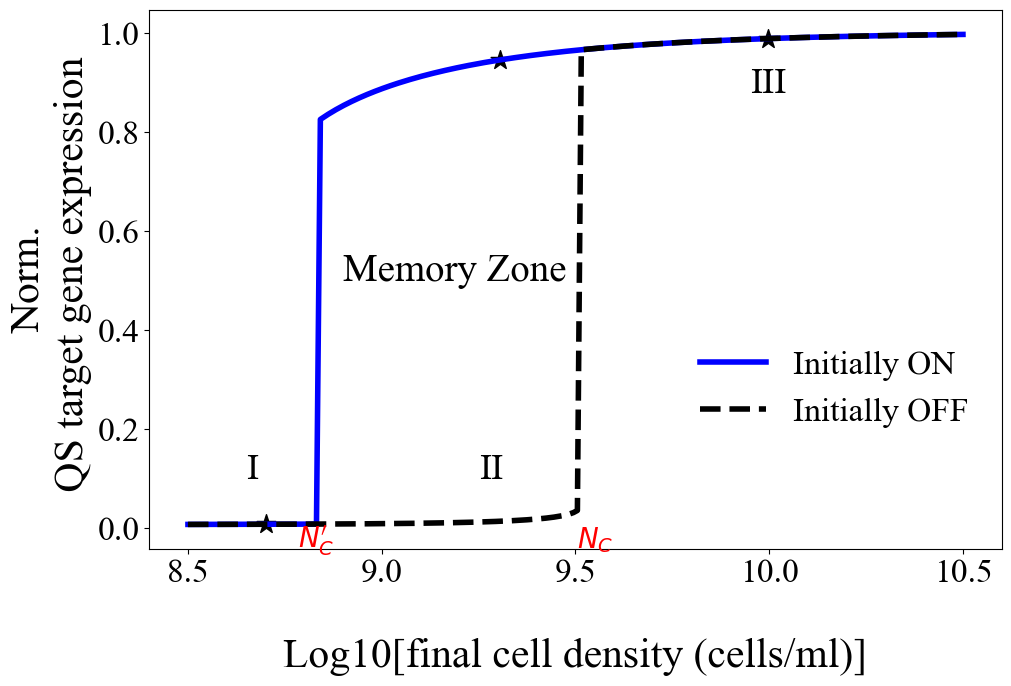

In [86]:
# Memory Zone Simulation: Normalized QS Target Gene vs Final Cell Density

# Define carrying capacity range (log10 space)
log_Nf_range = np.linspace(8.5, 10.5, 200)
LC = log_Nf_range.copy()

# Allocate storage
G_on = np.zeros_like(log_Nf_range)
G_off = np.zeros_like(log_Nf_range)

# Time vector (long enough for cells to reach carrying capacity)
t = np.linspace(0, 200000, 2000000)

# Initial density
n0 = 10 ** 8.5

# Loop through carrying capacities
for idx, logNf in enumerate(log_Nf_range):
    N_f = 10 ** logNf
    
    for state, label, store in zip(
        [ON_state, OFF_state],
        ["ON", "OFF"],
        [G_on, G_off]
    ):
        x0 = [*state[:5], 0, n0, state[7]]
        sol = odeint(qs_memory_model, x0, t, args=(N_f,))
        G_final = sol[-1, 7] / ON_state[7]
        
        if label == "ON":
            G_on[idx] = G_final
        else:
            G_off[idx] = G_final

# Plotting
fig, ax = plt.subplots(figsize=(11, 7))
ax.plot(LC, G_on, label="Initially ON", linewidth=4, color="b")
ax.plot(LC, G_off, label="Initially OFF", linewidth=4, linestyle="dashed", color="k")

# Mark representative points
for marker_logNf in [8.7, 9.3, 10.0]:
    idx = np.argmin(np.abs(LC - marker_logNf))
    ax.scatter(LC[idx], G_on[idx], c="k", marker="*", s=200)

# Annotations
ax.annotate("$N_C'$", xy=(8.83, -0.04), size=20, ha="center", color="r")
ax.annotate("$N_C$", xy=(9.55, -0.04), size=20, ha="center", color="r")

# Region labels
ax.text(8.65, 0.1, "I", size=26)
ax.text(9.25, 0.1, "II", size=26)
ax.text(9.95, 0.88, "III", size=26)

# Axes and formatting
ax.set_xlabel("\nLog10[final cell density (cells/ml)]", size=30)
ax.set_ylabel("Norm.\n QS target gene expression", size=30)
ax.legend(loc=(0.63, 0.2), frameon=False, fontsize=24)
ax.tick_params(axis='both', labelsize=24)
ax.text(8.9, 0.5, "Memory Zone", fontsize=28, color="k")
plt.show()

# Save data
memory_zone_df = pd.DataFrame({
    'Log10[Final Cell density]': LC,
    'G_on': G_on,
    'G_off': G_off
})
# memory_zone_df.to_excel("Memory_Fig2_B.xlsx", index=False)


# ODE based Analytical Modeling: Memory Zone Dependence on Cellular Parameters
## Memory term decreases with time and Fold Change



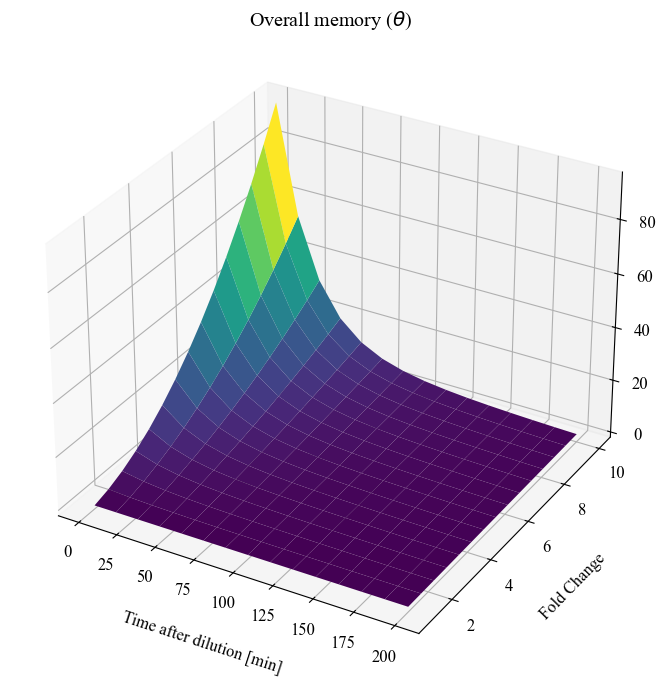

In [143]:


# Parameters
gam = 0.018
DT = 40.0  # min
gamma = np.log(2) / DT

# Time and Fold Change
t = np.linspace(1, 200, 15)
FC = np.linspace(1, 10, 15)
T, F = np.meshgrid(t, FC)

# Memory terms

# LuxI memory term
def f(t, FC):
    return ((gamma * (FC - 1) * t) / (np.exp(gamma * t) - 1))
# LuxI + LuxR memory term
def g(t, FC):
    return f(t, FC) + (FC - 1) * np.exp(-(gamma + gam) * t) * (1 + f(t, FC))

Z = g(T, F)

# Plot
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, F, Z, cmap='viridis', edgecolor='none', alpha=1)

# Axis labels
ax.set_xlabel("Time after dilution [min]", labelpad=15)
ax.set_ylabel("Fold Change", labelpad=15)
# Z-axis label replaced by title
plt.title("Overall memory ($\\theta$)", pad=0)

# Save and show
plt.tight_layout()
plt.savefig("Memory_Fig3_A.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()


## Affect of Fold Change on Memory Zone

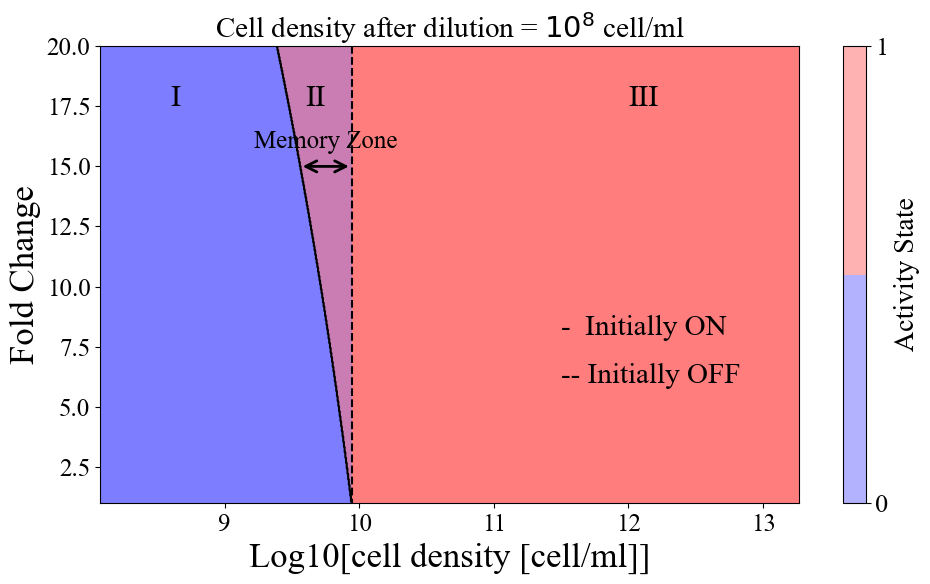

In [148]:

# --- Custom colormap: Blue (OFF) to Red (ON) ---
colors = [(0, 0, 1), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list('custom', colors, N=2)

# --- Parameters ---
DT = 40.0
b = 0.04
N0 = 1e8
If = 1000.0
v = 1e-12
gamma = np.log(2) / DT

def r(dt): return np.log(2) / dt  # Cell growth rate

# --- Memory terms ---
def f(t, FC):
    return (gamma * (FC - 1) * t) / (np.exp(gamma * t) - 1)

def g(t, FC):
    return f(t, FC) + (FC - 1) * np.exp(-(gamma + 0.018) * t) * (1 + f(t, FC))

# --- AHL production ---
def A(t, FC):
    return (N0 * b * v * If * (np.exp(r(DT) * t) - 1) / r(DT)) * (1 + g(t, FC))

def A_nm(t, FC):  # No memory
    return (N0 * b * v * If * (np.exp(r(DT) * t) - 1) / r(DT))

# --- Create meshgrid ---
t = np.linspace(10, 700, 1000)  # Time [min]
FC = np.linspace(1, 20, 1000)   # Fold change
X, Y = np.meshgrid(t, FC)
X_log = np.log10(N0 * np.exp(r(DT) * X))  # Cell density log scale

# --- Evaluate model ---
Z_m = A(X, Y)
Z_nm = A_nm(X, Y)

# --- Activation state matrices ---
State = (Z_m > 20).astype(int)
State_nm = (Z_nm > 20).astype(int)

# --- Expand states upward along each time column (once ON, stays ON) ---
for j in range(State.shape[1]):
    if np.any(State[:, j]):
        idx = np.argmax(State[:, j])
        State[idx:, j] = 1
    if np.any(State_nm[:, j]):
        idx = np.argmax(State_nm[:, j])
        State_nm[idx:, j] = 1

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot initially OFF state first (base layer)
img1 = ax.imshow(State_nm, extent=(X_log.min(), X_log.max(), FC.min(), FC.max()),
                 cmap=cmap, aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)

# Overlay initially ON state
img2 = ax.imshow(State, extent=(X_log.min(), X_log.max(), FC.min(), FC.max()),
                 cmap=cmap, aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)

# Contours
ax.contour(X_log, Y, State_nm, levels=[0.5], colors='k', linestyles='dashed', linewidths=1.5)
ax.contour(X_log, Y, State, levels=[0.5], colors='k', linestyles='solid', linewidths=1.5)

# Labels
ax.set_title("Cell density after dilution = $10^8$ cell/ml", size=21)
ax.set_xlabel("Log10[cell density [cell/ml]]", size=25)
ax.set_ylabel("Fold Change", size=25)
ax.text(8.6, 17.5, "I", size=22)
ax.text(9.6, 17.5, "II", size=22)
ax.text(12, 17.5, "III", size=22)
ax.text(11.5, 8, "-  Initially ON", size=21)
ax.text(11.5, 6, "-- Initially OFF", size=21)

# Double-headed arrow annotation for "Memory Zone"
arrow_y = 13  # y-coordinate at middle of purple region
arrow_x_start = 8.2
arrow_x_end = 10.8
if x_solid is not None and x_dashed is not None:
    plt.annotate(
        '', 
        xy=(x_solid, 15), 
        xytext=(x_dashed, 15),
        arrowprops=dict(
            arrowstyle='<->',
            color='black',
            lw=2,
            mutation_scale=20
        )
    )
    # Add "Memory Zone" label above the arrow
    plt.text(
        (x_solid + x_dashed) / 2, 15.5, 
        'Memory Zone', 
        ha='center', va='bottom', 
        fontsize=18, color='black'
    )

# Colorbar
cbar = fig.colorbar(img2, ax=ax, ticks=[0, 1])
cbar.set_label('Activity State', size=20)
cbar.ax.tick_params(labelsize=19)

ax.tick_params(axis='both', which='major', labelsize=18)
plt.tight_layout()
plt.savefig("Memory_Fig4_A_with_memory_zone.tiff", format='tiff', dpi=300, bbox_inches='tight')
plt.show()

# --- Save data to Excel ---
data = pd.DataFrame({
    'Log10[cell density]': X_log.flatten(),
    'Fold Change': Y.flatten(),
    'Activity State Initially ON': State.flatten(),
    'Activity State Initially OFF': State_nm.flatten()
})
data.to_excel('Memory_Fig4_A.xlsx', index=False)


## Higher Fold Changes Expand the Memory Zone (Purple Region)
An increase in fold change leads to a broader memory zone, where past states influence current QS activation.


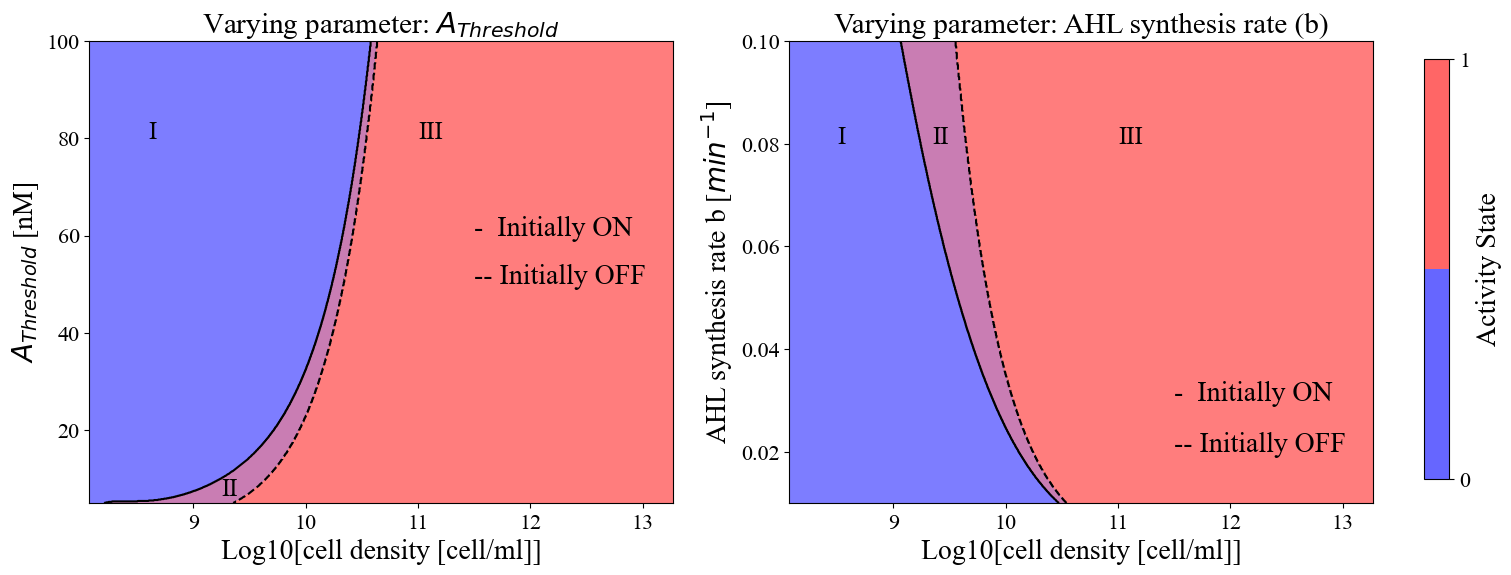

In [158]:


# --- Custom colormap ---
colors = [(0, 0, 1), (1, 0, 0)]  # Blue to Red
cmap = LinearSegmentedColormap.from_list('custom', colors, N=2)

# --- Parameters ---
DT = 40.
FC = 10
N0 = 10**8
If = 1000.
v = 1e-12
gamma = np.log(2) / DT

def r(dt): return np.log(2) / dt

# --- Memory terms ---
def f(t): return (gamma * (FC - 1) * t) / (np.exp(gamma * t) - 1)
def g(t): return f(t) + (FC - 1) * np.exp(-(gamma + 0.018) * t) * (1 + f(t))

# --- AHL production ---
def A(t, b): return (N0 * b * v * If * (np.exp(r(DT) * t) - 1) / r(DT)) * (1 + g(t))
def A_nm(t, b): return (N0 * b * v * If * (np.exp(r(DT) * t) - 1) / r(DT))

t = np.linspace(10, 700, 1000)

# === FIRST PLOT: Varying A_threshold ===
th_values = np.linspace(5, 100, 1000)
X1, Y1 = np.meshgrid(t, th_values)
Z1_m = A(X1, 0.04)
Z1_nm = A_nm(X1, 0.04)

State1 = (Z1_m > Y1).astype(int)
State1_nm = (Z1_nm > Y1).astype(int)
X1_log = np.log10(N0 * np.exp(r(DT) * X1))

# === SECOND PLOT: Varying b ===
b_values = np.linspace(0.01, 0.1, 1000)
th_const = np.ones_like(b_values) * 20
X2, Y2 = np.meshgrid(t, b_values)
Z2_m = A(X2, Y2)
Z2_nm = A_nm(X2, Y2)

State2 = (Z2_m > th_const[:, None]).astype(int)
State2_nm = (Z2_nm > th_const[:, None]).astype(int)
X2_log = np.log10(N0 * np.exp(r(DT) * X2))

# === PLOTTING SIDE-BY-SIDE ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=False)

# Plot 1: Varying A_threshold
# Plot no-memory (blue) first, then memory (red) with transparency
ax1.imshow(State1_nm, extent=(X1_log.min(), X1_log.max(), 5, 100), cmap=cmap,
           aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)
ax1.imshow(State1, extent=(X1_log.min(), X1_log.max(), 5, 100), cmap=cmap,
           aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)
ax1.contour(X1_log, Y1, State1_nm, levels=[0.5], colors='k', linestyles='dashed', linewidths=1.5)
ax1.contour(X1_log, Y1, State1, levels=[0.5], colors='k', linestyles='solid', linewidths=1.5)
ax1.set_title("Varying parameter: $A_{Threshold}$", size=21)
ax1.set_xlabel("Log10[cell density [cell/ml]]", size=20)
ax1.set_ylabel("$A_{Threshold}$ [nM]", size=20)
ax1.text(8.6, 80, "I", size=18)
ax1.text(9.25, 6.5, "II", size=18)
ax1.text(11, 80, "III", size=18)
ax1.text(11.5, 60, "-  Initially ON", size=20)
ax1.text(11.5, 50, "-- Initially OFF", size=20)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Plot 2: Varying b
# Plot no-memory (blue) first, then memory (red) with transparency
ax2.imshow(State2_nm, extent=(X2_log.min(), X2_log.max(), 0.01, 0.1), cmap=cmap,
           aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)
ax2.imshow(State2, extent=(X2_log.min(), X2_log.max(), 0.01, 0.1), cmap=cmap,
           aspect='auto', origin='lower', alpha=0.3, vmin=0, vmax=1)
ax2.contour(X2_log, Y2, State2_nm, levels=[0.5], colors='k', linestyles='dashed', linewidths=1.5)
ax2.contour(X2_log, Y2, State2, levels=[0.5], colors='k', linestyles='solid', linewidths=1.5)
ax2.set_title("Varying parameter: AHL synthesis rate (b)", size=21)
ax2.set_xlabel("Log10[cell density [cell/ml]]", size=20)
ax2.set_ylabel("AHL synthesis rate b [$min^{-1}$]", size=20)
ax2.text(8.5, 0.08, "I", size=18)
ax2.text(9.35, 0.08, "II", size=18)
ax2.text(11, 0.08, "III", size=18)
ax2.text(11.5, 0.03, "-  Initially ON", size=20)
ax2.text(11.5, 0.02, "-- Initially OFF", size=20)
ax2.tick_params(axis='both', which='major', labelsize=16)

# Shared colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7])
colorbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap), cax=cbar_ax, ticks=[0, 1])
colorbar.set_label('Activity State', size=20)
colorbar.ax.tick_params(labelsize=16)
colorbar.solids.set_alpha(0.6)  # Transparent colorbar

plt.savefig("Fig_S7_combined.pdf", bbox_inches='tight')
plt.show()


## Higher AHL basal synthesis rate (`b`) and lower AHL activation threshold (`A_Threshold`) amplify memory effects